In [5]:
import sys
sys.path.insert(0, '/Users/kvolk/Documents/GitHub/SBDynT/src')
import run_reb
import rebound
import numpy as np
import horizons_api
import tools




In [23]:
horizons_api.query_sb_from_jpl(des='K14X40T',clones=0)

(1,
 2457019.5,
 20.608044425294036,
 24.460232670477833,
 -0.43401061748237785,
 -0.8946950688262664,
 0.8022771544245897,
 -0.15424196522623565)

In [36]:
sbody = 'K14X40T'
sim= rebound.Simulation()
flag, epoch, sim = run_reb.initialize_simulation(planets=['Jupiter','Saturn','Uranus','Neptune'],des=sbody,clones=105)
#sim.status()
#print(epoch)
#com = sim.calculate_com()

#p = sim.particles[sbody+"_bf"]
#o = p.calculate_orbit(com)
#r2d = 180./np.pi
#print("%20.15E\t%20.15E\t%20.15E\t%20.15E\t%20.15E\t%20.15E\n" % (o.a,o.e,o.inc*r2d, o.Omega*r2d,o.omega*r2d,r2d*o.M))

In [37]:
tmax = 1e6
tout = 1e3

sim = run_reb.run_simulation(sim, tmax=tmax, tout=tout,filename="archive.bin",deletefile=True,mindist=20.)

0.0
1000000.0


/Users/kvolk/opt/anaconda3/envs/jpl-sbdb/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


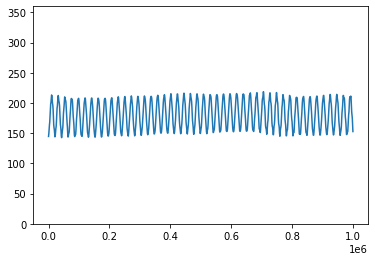

In [38]:
a = np.zeros(1);e = np.zeros(1);inc = np.zeros(1);phi = np.zeros(1)
t = np.zeros(1);
sa = rebound.SimulationArchive('archive.bin')
print(sa.tmin)
print(sa.tmax)
for i,sim in enumerate(sa):
    p = sim.particles[sbody+"_5"]
    n = sim.particles['neptune']
    com = sim.calculate_com()
    o = p.calculate_orbit(com)
    on = n.calculate_orbit(com)


    t = np.append(t, sim.t)
    a = np.append(a, o.a)
    e = np.append(e, o.e)
    inc = np.append(inc, o.inc*r2d)
    lamda = o.Omega+o.omega+o.M
    lamdan = on.Omega+on.omega+on.M
    pt = 3*lamda - 2*lamdan - (o.Omega+o.omega)
    pt = tools.mod2pi(pt)
    phi = np.append(phi,pt)
    
t = np.delete(t,0)
a= np.delete(a,0)
e = np.delete(e,0)
inc = np.delete(inc,0)

phi = np.delete(phi,0)



import matplotlib.pyplot as plt
%matplotlib inline
plt.ylim([0,360])
plt.plot(t,phi*180/np.pi)

In [ ]:
def new_run_simulation(sim, tmax=0, tout=0,filename="archive.bin",deletefile=True,maxdist=1500,mindist=4.):
    '''
    run a mercurius simulation saving to a simulation archive every tout
    removing particles if they exceed the maximum distance or go below
    the minumum distance
    '''
    sim.automateSimulationArchive("archive.bin",interval=tout,deletefile=deletefile)
    sim.integrator = 'ias15'
    sim.dt = 0.0001
    #sim.collision = "direct"
    #sim.ri_mercurius.hillfac = 3.
    #sim.collision_resolve = "merge"


    sim.integrate(tmax)
    return sim

In [ ]:
def new_initialize_simulation(planets=['Jupiter','Saturn','Uranus','Neptune'], des='', clones=0):
    '''
    inputs:
        (optional) list of planets - defaults to JSUN
        small body designation
        (optional) number of clones - defaults to none
    outputs:
        flag (integer: 0 if failed, 1 if successful)
        epoch of the simulation start (JD)
        rebound simulation instance with planets and test particles added
    '''
    
    #make all planet names lowercase
    planets = [pl.lower() for pl in planets]
    #create an array of planets not included in the simulation
    #will be used to correct the simulation's barycenter for their absence
    notplanets = []


    # initialize simulation variable
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    #set up small body variables
    ntp = 1 + clones
    sbx = np.zeros(ntp)
    sby = np.zeros(ntp)
    sbz = np.zeros(ntp)
    sbvx = np.zeros(ntp)
    sbvy = np.zeros(ntp)
    sbvz = np.zeros(ntp)

    #get the small body's position and velocity
    flag, epoch, sbx, sby, sbz, sbvx, sbvy, sbvz = horizons_api.query_sb_from_jpl(des=des,clones=clones)
    if(flag<1):
        print("initialize_simulation failed at horizons_api.query_sb_from_jpl")
        return 0, 0., sim
    
    #set up massive body variables    
    npl = len(planets) + 1 #for the sun

    #define the planet-id numbers used by Horizons for the barycenters of each
    #major planet in the solar system
    planet_id = {1: 'mercury', 2: 'venus', 3:'earth', 4:'mars', 5: 'jupiter', 6:'saturn', 7:'uranus', 8:'neptune'}

    #array of GM values queried January 2022
    #(there isn't a way to get this from Horizons, so we just have to hard code it)
    #values for giant planet systems are from Park et al. 2021 DE440 and DE441, 
    #https://doi.org/10.3847/1538-3881/abd414
    #all in km^3 kg^–1 s^–2
    #G = 6.6743015e-20 #in km^3 kg^–1 s^–2
    SS_GM = np.zeros(9)
    SS_GM[0] = 132712440041.93938 #Sun
    SS_GM[1] = 22031.86855 #Mercury
    SS_GM[2] = 324858.592 #Venus
    SS_GM[3] = 403503.235502 #Earth-Moon
    SS_GM[4] = 42828.375214 #Mars
    SS_GM[5] = 126712764.10 #Jupiter system
    SS_GM[6] = 37940584.8418 #Saturn system
    SS_GM[7] = 5794556.4 #Uranus system
    SS_GM[8] = 6836527.10058 #Neptune system

    #set of reasonable whfast simulation timesteps for each planet
    #(1/20 of its orbital period for terrestrial planets, 1/30 for giants)
    dt = [0.012,0.03,0.05,0.09,0.4,0.98,2.7,5.4]

    #add the mass of any not-included planets to the sun
    msun = SS_GM[0]
    #start with shortest timestep
    sim.dt = dt[0]
    for i in range(1,9):
        if (not(planet_id[i] in planets )):
            msun+=SS_GM[i]
            notplanets.append(planet_id[i])
            #make the timestep bigger
            sim.dt = dt[i]

    #sun's augmented mass in solar masses
    msun = msun/SS_GM[0]
    radius = 695700.*6.68459e-9
    sim.add(m=msun,r=radius,x=0.,y=0.,z=0.,vx=0.,vy=0.,vz=0.,hash='sun')


    #set the initial correction for the included planets'
    #position and velocities to zero
    sx = 0.;sy = 0.;sz=0.; svx = 0;svy = 0.;svz = 0.;

    #calculate the correction
    if(len(notplanets)>0):
        #create a temporary simulation to calculate the barycenter of the sun+not
        #included planets so their mass can be added to the sun in the 
        #simulation
        tsim = rebound.Simulation()
        tsim.units = ('yr', 'AU', 'Msun')
        tsim.add(m=1.0,x=0.,y=0.,z=0.,vx=0.,vy=0.,vz=0.)
        for pl in notplanets:
            flag, mass, radius, [x, y, z], [vx, vy, vz] = horizons_api.query_horizons_planets(obj=pl,epoch=epoch)
            if(flag<1):
                print("initialize_simulation failed at horizons_api.query_horizons_planets for ", pl)
                return 0, 0., sim
            tsim.add(m=mass,r=radius,x=x,y=y,z=z,vx=vx,vy=vy,vz=vz)
        #calculate the barycenter of the sun + missing planets
        com = tsim.calculate_com()
        #reset the corrections to the positions and velocities
        sx = -com.x; sy = -com.y; sz = -com.z; 
        svx = -com.vx; svy = -com.vy; svz = -com.vz;


    #add each included planet to the simulation and correct for the missing planets
    for pl in planets:
        flag, mass, radius, [x, y, z], [vx, vy, vz] = horizons_api.query_horizons_planets(obj=pl,epoch=epoch)
        if(flag<1):
            print("initialize_simulation failed at horizons_api.query_horizons_planets for ", pl)
            return 0, 0., sim
        #correct for the missing planets
        x+=sx;y+=sy;z+=sz; vx+=svx;vy+=svy;vz+=svz;
        sim.add(m=mass,r=radius,x=x,y=y,z=z,vx=vx,vy=vy,vz=vz,hash=rebound.hash(pl))

    sim.N_active = npl

    if(clones>0):
        for i in range(0,ntp):
            if(i==0):
                sbhash = des + '_bf'
            else:
                sbhash = str(des) + '_' + str(i)
            #correct for the missing planets
            sbx[i]+=sx;sby[i]+=sy;sbz[i]+=sz; sbvx[i]+=svx;sbvy[i]+=svy;sbvz[i]+=svz;
            sim.add(m=0.,x=sbx[i],y=sby[i],z=sbz[i],vx=sbvx[i],vy=sbvy[i],vz=sbvz[i],hash=sbhash)
    else:
        sbx+=sx;sby+=sy;sbz+=sz; sbvx+=svx;sbvy+=svy;sbvz+=svz;
        sbhash = des + '_bf'
        sim.add(m=0.,x=sbx,y=sby,z=sbz,vx=sbvx,vy=sbvy,vz=sbvz,hash=sbhash)

    sim.move_to_com()


    return 1, epoch, sim
